# Insulin Intake Prediction using LightGBM

Light Gradient-Boosting Machine, is an open-source distributed gradient-boosting framework for machine learning, originally developed by Microsoft.

# Mount the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks/4_Trimester_Fall2024/Project/Codes/


Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/4_Trimester_Fall2024/Project/Codes


# Import required packages

In [2]:
import lightgbm as lgb #Imports the LightGBM library for gradient boosting models.
import pandas as pd # Imports pandas for data manipulation and analysis.
import numpy as np # Imports NumPy for numerical operations and handling arrays.
import matplotlib.pyplot as plt  # Imports Matplotlib for creating visualizations.
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report # Imports evaluation metrics for model performance.
from sklearn.model_selection import train_test_split #  Imports a function to split data into training and testing sets.
from sklearn.preprocessing import label_binarize #  Imports a function to convert categorical labels into a binary format.
import seaborn as sns # Imports Seaborn for enhanced data visualization.
from sklearn.metrics import roc_curve, auc # Imports functions to compute and plot the ROC curve and calculate the Area Under the Curve (AUC).
from imblearn.over_sampling import SMOTE # Imports the SMOTE technique for handling class imbalance by oversampling minority classes.

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Load the dataset and cleanse the data

In [3]:
# Load your dataset
data = pd.read_csv('diabetic_data_clean.csv')
# Reads the diabetic_data_clean.csv file into a pandas DataFrame named data for further data manipulation and analysis.

In [4]:
data.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,15738,63555939,Caucasian,Female,10,3,3,4,12,InternalMedicine,...,No,2,No,No,No,No,No,Ch,Yes,NO
1,40926,85504905,Caucasian,Female,5,1,3,7,7,Family/GeneralPractice,...,No,1,No,No,No,No,No,Ch,Yes,<30
2,42570,77586282,Caucasian,Male,9,1,6,7,10,Family/GeneralPractice,...,No,2,No,No,No,No,No,No,Yes,NO
3,84222,108662661,Caucasian,Female,6,1,1,7,3,Cardiology,...,No,0,No,No,No,No,No,No,Yes,NO
4,236316,40523301,Caucasian,Male,9,1,3,7,6,Cardiology,...,No,0,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Here we drop irrelevant columns and handle categorical variables
data = data.drop(columns=['encounter_id', 'patient_nbr', 'readmitted'])  # Drop non-predictive columns
# Removes the encounter_id, patient_nbr, and readmitted columns from the DataFrame data, as these columns are considered non-predictive for the analysis.

In [6]:
# Define features and target variable
X = data.drop(columns=['insulin'])  # Features. Creates a new DataFrame X containing all features except the insulin column, which will be used as input features for the model.
y = data['insulin']  # Target variable. Extracts the insulin column from data and assigns it to y, representing the target variable the model will predict.

In [7]:
# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)
# Converts categorical features in X into one-hot encoded binary columns, dropping the first category to avoid multicollinearity.
# This transforms categorical data into a format suitable for machine learning models.

In [8]:
# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42) # Initializes the SMOTE (Synthetic Minority Oversampling Technique) object to handle class imbalance by generating synthetic samples for the minority class, with a fixed random state for reproducibility.
X, y = smote.fit_resample(X, y) # Applies SMOTE to the feature matrix X and target vector y, creating a balanced dataset by oversampling the minority class. The result is a resampled dataset with balanced class distribution.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# Split the dataset to Train and Test Sets

In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Splits the dataset X (features) and y (target) into training and testing sets, with 20% of the data allocated to testing.
# The random_state=42 ensures reproducibility by controlling the random shuffling of data.

In [10]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train) # Converts the training features X_train and labels y_train into a LightGBM-specific dataset object (train_data) for model training.
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) # Converts the testing features X_test and labels y_test into a LightGBM dataset (test_data) for evaluation, using train_data as a reference to maintain consistent handling of features.

# Set LightGBM parameters

In [11]:
# Set LightGBM parameters for classification
params = {
    'objective': 'multiclass',  # Specifies that the task is a multiclass classification problem. Use 'binary' if the target variable (insulin) has only two categories.
    'metric': 'multi_logloss',  # Defines the evaluation metric as the multi-class logarithmic loss. For binary classification, use 'binary_logloss'.
    'boosting_type': 'gbdt', # Uses Gradient Boosting Decision Trees (GBDT) as the boosting method, which is the default boosting type in LightGBM.
    'learning_rate': 0.05,  # Slightly higher learning rate for better convergence. Controls the step size in updating weights. A lower learning rate improves generalization but requires more iterations.
    'num_leaves': 64,  # Increased number of leaves for more complex models. Sets the maximum number of leaves in each tree. Increasing this allows for more complex models but can lead to overfitting if too high.
    'max_depth': 10,  # Set a maximum depth to prevent overfitting. Limits the depth of the trees to control model complexity and prevent overfitting.
    'min_data_in_leaf': 50,  # Minimum number of data in a leaf. Sets the minimum number of samples a leaf must have to ensure that leaves don’t become too small, reducing the risk of overfitting.
    'verbose': -1, # Suppresses detailed output logs during training.
    'num_class': len(y.unique())  # Set the number of classes if multiclass. Automatically sets the number of output classes based on the unique values in the target variable y (necessary for multiclass classification).
}

# Set early stopping and train the model

In [12]:
# Train the model with early stopping to prevent overfitting
callbacks = [lgb.early_stopping(stopping_rounds=50)] # Sets an early stopping callback to halt training if the validation performance doesn't improve for 50 consecutive rounds, preventing overfitting and saving time.

model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data], callbacks=callbacks)
# Trains the LightGBM model using the specified parameters (params) and the train_data for up to 1000 boosting rounds, while evaluating on test_data.
# The training stops early if performance plateaus, as determined by the early stopping callback.

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.486149


# Make predictions

In [13]:
# Make predictions
y_pred_proba = model.predict(X_test)  # Get predicted probabilities
# Uses the trained LightGBM model to predict the probabilities for each class for the test set X_test.
# The output, y_pred_proba, contains the predicted probabilities for each class, rather than hard classifications.

In [14]:
# For multiclass classification, take the class with the highest probability
y_pred_class = y_pred_proba.argmax(axis=1)
# Converts the predicted probabilities y_pred_proba into class predictions by selecting the class with the highest probability for each sample.
# The argmax(axis=1) function returns the index of the maximum value along each row (representing the class with the highest probability), resulting in y_pred_class, the predicted class labels.

# Calcualte and print model metrics

In [15]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_class) # Calculates the accuracy of the model by comparing the predicted class labels (y_pred_class) with the true labels (y_test). Accuracy is the proportion of correct predictions.
f1 = f1_score(y_test, y_pred_class, average='weighted')  # Computes the F1 score with weighted averaging, which considers the imbalance in the class distribution. The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics.
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Calculates the ROC AUC score for multiclass classification using the one-vs-rest (OvR) approach. It measures the model's ability to distinguish between classes, with a higher value indicating better performance.

In [16]:
# Print metrics
print(f'Accuracy: {accuracy:.4f}')  # Prints the accuracy of the model, formatted to 4 decimal places.
print(f'F1 Score: {f1:.4f}') # Prints the F1 score with weighted averaging, formatted to 4 decimal places.
print(f'ROC AUC: {roc_auc:.4f}') # Prints the ROC AUC score for multiclass classification, formatted to 4 decimal places.
print("\nClassification Report:\n", classification_report(y_test, y_pred_class)) # Prints a detailed classification report showing precision, recall, F1 score, and support for each class in the test set.

Accuracy: 0.8080
F1 Score: 0.8084
ROC AUC: 0.9553

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      4444
           1       0.74      0.76      0.75      4454
           2       0.82      0.81      0.82      4558
           3       0.75      0.74      0.75      4456

    accuracy                           0.81     17912
   macro avg       0.81      0.81      0.81     17912
weighted avg       0.81      0.81      0.81     17912



# Generate and plot confusion matrix

In [17]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Calculates the confusion matrix for the test set, comparing the true labels (y_test) with the predicted class labels (y_pred_class).
# The confusion matrix provides a summary of the model's performance, showing the counts of true positives, false positives, true negatives, and false negatives for each class.

In [18]:
# Calculate percentage confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Converts the confusion matrix cm into percentage values by normalizing each row (representing a class) so that the sum of each row equals 100%.

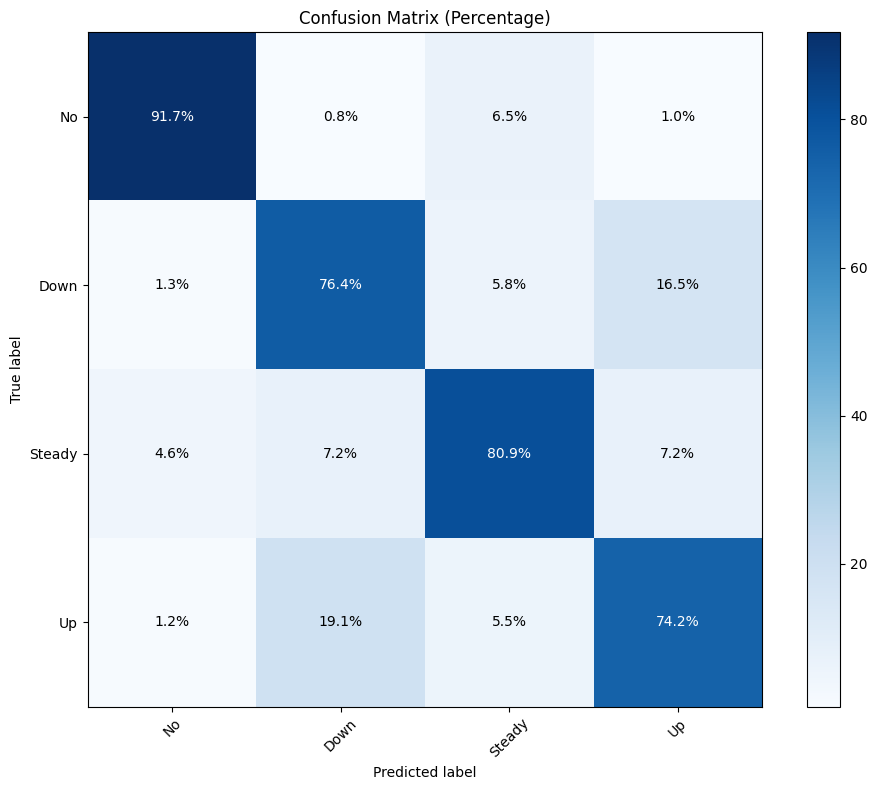

In [19]:
# Define custom labels
custom_labels = ['No', 'Down', 'Steady', 'Up']  # Defines custom labels for the classes in the confusion matrix. These labels replace the default numerical labels.

# Plot Confusion Matrix
plt.figure(figsize=(10, 8)) # Sets the figure size to 10x8 inches for better visibility of the confusion matrix plot.
plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues) # Visualizes the confusion matrix cm_percentage as an image, using a blue color map for styling.
plt.title('Confusion Matrix (Percentage)') # Adds the title "Confusion Matrix (Percentage)" to the plot.
plt.colorbar() # Displays a color bar next to the matrix, showing the intensity scale of the colors.

# Adjust ticks with custom labels
tick_marks = np.arange(len(custom_labels)) # Creates tick marks for the custom labels, one for each class.
plt.xticks(tick_marks, custom_labels, rotation=45) # Sets the x-axis labels (predicted labels) with the custom labels and rotates them 45 degrees for readability.
plt.yticks(tick_marks, custom_labels) # Sets the y-axis labels (true labels) with the custom labels.

# Show percentage values on the matrix
thresh = cm_percentage.max() / 2.0 # Calculates a threshold for the text color: values above the threshold will be displayed in white, and values below will be displayed in black.
for i in range(cm_percentage.shape[0]): # Loops through each row of the confusion matrix to add the percentage values to the plot.
    for j in range(cm_percentage.shape[1]):
        plt.text(j, i, f'{cm_percentage[i, j]:.1f}%', ha='center', va='center', # Adds the percentage text to each cell in the matrix, with white or black color depending on the background intensity.
                 color='white' if cm_percentage[i, j] > thresh else 'black')

plt.ylabel('True label') # Sets the label for the y-axis as "True label".
plt.xlabel('Predicted label') # Sets the label for the x-axis as "Predicted label".
plt.tight_layout() # Adjusts the layout of the plot to make sure labels and titles fit well within the figure.
plt.show() # Displays the plot.

# Plot Receiver-operating characteristic curve (ROC)

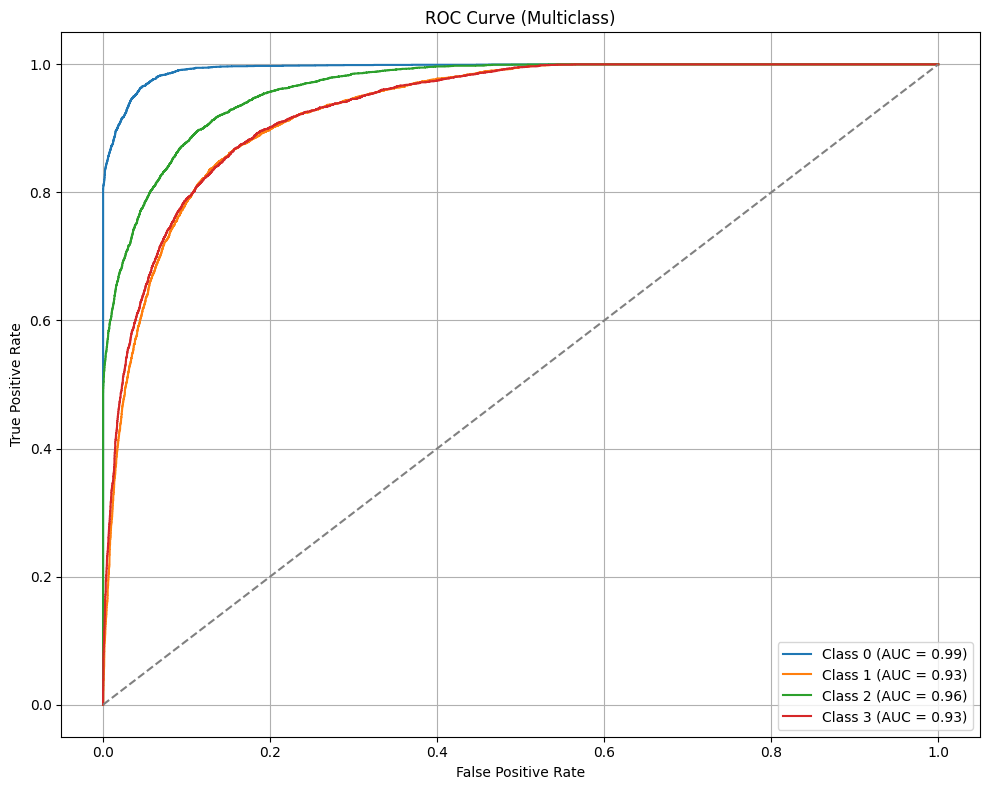

In [20]:
# Plot ROC curve for multiclass classification
# One-hot encode the true labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
# Binarizes the true labels y_test into a format suitable for multiclass ROC curve analysis, where each class is converted into a separate binary vector (one-hot encoding).
# This step is necessary because the roc_curve function requires binary labels for each class.

fpr, tpr, roc_auc_dict = {}, {}, {} # Initializes empty dictionaries to store the False Positive Rate (FPR), True Positive Rate (TPR), and AUC for each class.
for i in range(y_test_bin.shape[1]): # Loops through each class (the number of columns in the binarized true labels y_test_bin).
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i]) # Computes the False Positive Rate (FPR) and True Positive Rate (TPR) for each class using the roc_curve function. It compares the binarized true labels (y_test_bin[:, i]) with the predicted probabilities (y_pred_proba[:, i]) for the current class.
    roc_auc_dict[i] = auc(fpr[i], tpr[i]) # Calculates the Area Under the Curve (AUC) for each class using the auc function, which measures the model's ability to distinguish between classes.

# Plot all ROC curves
plt.figure(figsize=(10, 8)) # Creates a new figure with a size of 10x8 inches for the ROC curve plot.
for i in range(y_test_bin.shape[1]): # Loops through each class again to plot the ROC curve for each class.
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_dict[i]:.2f})') # Plots the ROC curve for the current class using the previously computed FPR and TPR. The AUC is displayed in the legend for each class.

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Plots a diagonal line representing the performance of a random classifier (i.e., the line where the FPR and TPR are equal).

# Customize the plot
plt.title('ROC Curve (Multiclass)') # Sets the title of the plot to "ROC Curve (Multiclass)".
plt.xlabel('False Positive Rate') #Labels the x-axis as "False Positive Rate".
plt.ylabel('True Positive Rate') # Labels the y-axis as "True Positive Rate".
plt.legend(loc='lower right') # Displays the legend in the lower right corner of the plot, showing the class labels and their corresponding AUC values.
plt.grid(True) # Adds a grid to the plot for better readability.
plt.tight_layout() # Adjusts the layout of the plot to ensure everything fits well, avoiding overlapping labels.
plt.show() # Displays the ROC curve plot.